# ENTREGA DATOS
#### Sara Blanco López
#### Josep Peiró Ramos

In [1]:
import os
from preprocessing import Preprocessing, SplitAudio, Reconstruction
import torchaudio

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

import pandas as pd
from IPython.display import Audio

c:\Users\jpeir\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


Para este trabajo vamos a mostrar el archivo ejecutado. 

Lo que se muestra ahora son una pequeña porción de los datos,  no podemos subir todos los archivos de audio al aula virtual, ya que sería inasumible, ocupan más de 9 Gigabytes.

Se debe tener en cuenta que son necesarias tener todos los archivos que estamos subiendo en la tarea en una misma carpeta para que esto pueda ejecutarse correctamente.

Estamos utilizando un conjunto de datos de 5359 audios de 10 segundos.

En el proceso de preprocesamiento hemos reducido la frecuencia de 48 kilohercios a 16 kHz. Luego hemos dividido cada archivo en otros dos de 4,2 segundos, porque esto nos hará falta para que sean compatibles con otro conjunto de datos. Por eso de cada archivo aparecen dos muestras que representan cada una de las particiones que hemos hecho.

Luego,  hemos transformado al espectograma de Mel de cada archivo, con 256 muestras discretas de 256 frecuencias, dándonos como resultado una matriz de 256 x 256.

El procesamiento se hace automáticamente.

In [2]:
ruta_carpeta = "./MusicCaps"  # Carpeta con los audios

archivos = os.listdir(ruta_carpeta)[:50] # Seleccionamos los 50 primeros

# Preprocesamiento
X = []
metadata = []
sample_rate_red = 16000
for archivo in archivos:
    waveform, samp_rt = torchaudio.load("./MusicCaps/" + archivo) # Carga de datos
    f, s = SplitAudio(waveform, sample_rate = samp_rt, new_sample_rate = sample_rate_red) # División en 2 muestras de 4,2 seg

    f_spec, f_maxi, f_mini = Preprocessing(f, 16000, resampler_f = False) # Convirtiendo a espectograma
    s_spec, s_maxi, s_mini = Preprocessing(s, 16000, resampler_f = False)

    X += [f_spec, s_spec] # Guardando
    metadata += [{"nombre":archivo, "parte":"first", "minimum":f_mini, "maximum":f_maxi},
                 {"nombre":archivo, "parte":"second", "minimum":s_mini, "maximum":s_maxi}]

c:\Users\jpeir\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


Mostramos unos resultados resumidos, como cuántos datos hemos cargado, 100 (50 x 2). Cada dato es de 256x256, son tensorees de pytorch. Y mostramos un valor aleatorio cualquiera, para que sea visible que es un número decimal.

Todos los valores están entre 0 y 1

In [3]:
print(len(X)) # Cantidad de muestras (la hemos fijado para que sean estas)
print(X[43].shape) # Tamaño del dato aleatorio
print(X[39][235][168]) # Un atributo aleatorio

100
torch.Size([256, 256])
tensor(0.6597)


# VISUALIZACIÓN PARA LA ENTREGA

## Visualizacion de un espectograma cualquiera

Mostramos un dato cualquiera. Vamos a mostrar su espectograma, como si fuese una imagen, como es una matriz de datos es posible hacerlo así.

Este espectograma es lo que queremos reconstruir.

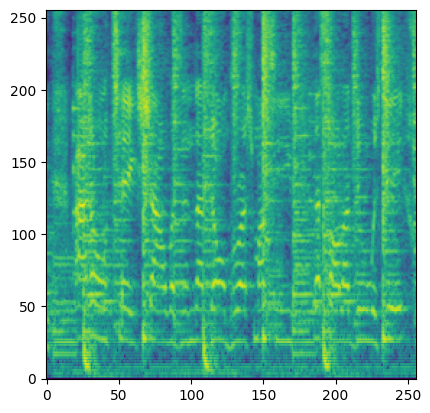

In [4]:
plt.imshow(X[-5],origin='lower')

Esta imagen no se puede interpretar, pero es la forma que tienen los datos y lo que reconstruiremos con el autoencoder.

## Visualización de estadísticos básicos de los espectogramas

Utilizando pairplot para que se cumplan los requisitos mínimos de la entrega.

De aquí, para cada frecuencia de cada dato, vamos a mostrar unos pequeños estadísticos. Tiene sentido hacerlo así porque se puede llegar a inferencias más interesantes, viendo como la media y la varianza están relacionadas en cada frecuencia. Y si mostrasemos estos estadísticos por audio probablemente la información quedaría demasiado resumida.

Percatarse de que este gráfico es simétrico.

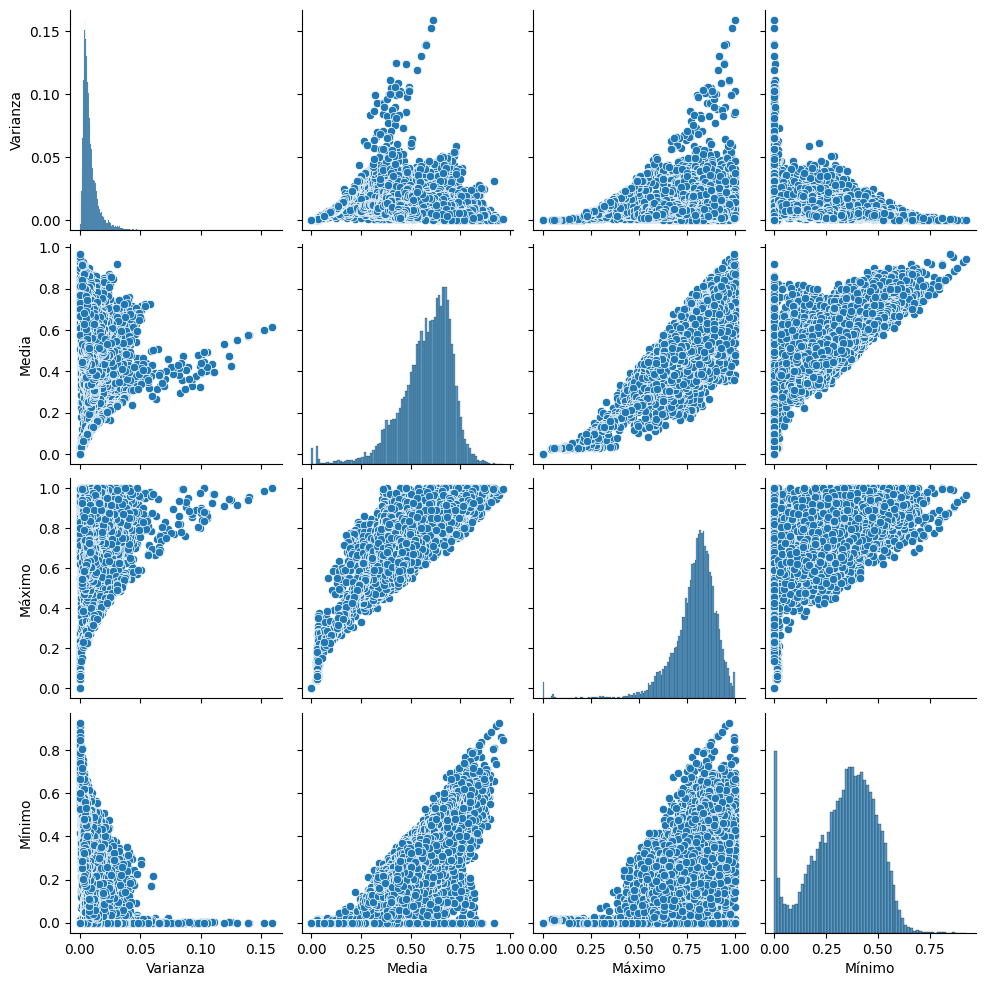

In [5]:
estadisticos = []
for i in X:
    for j in i:
        varianza = np.var(j.tolist(), axis=0)
        promedio = np.mean(j.tolist(), axis=0)
        maximo = np.max(j.tolist(), axis=0)
        minimo = np.min(j.tolist(), axis=0)
        estadisticos.append((varianza, promedio, maximo, minimo))

sns.pairplot(pd.DataFrame(estadisticos, columns=("Varianza", "Media", "Máximo", "Mínimo")))
plt.show()

## Visualización del t-SNE
Finalmente vamos a mostrar una descomposición de la t-SNE de la forma de los datos.

Esta representación es especialmente valiosa porque es un embebimiento no lineal sobre 2 diemnsiones, de manera anaáloga a lo que ocurre en un autoencoder.

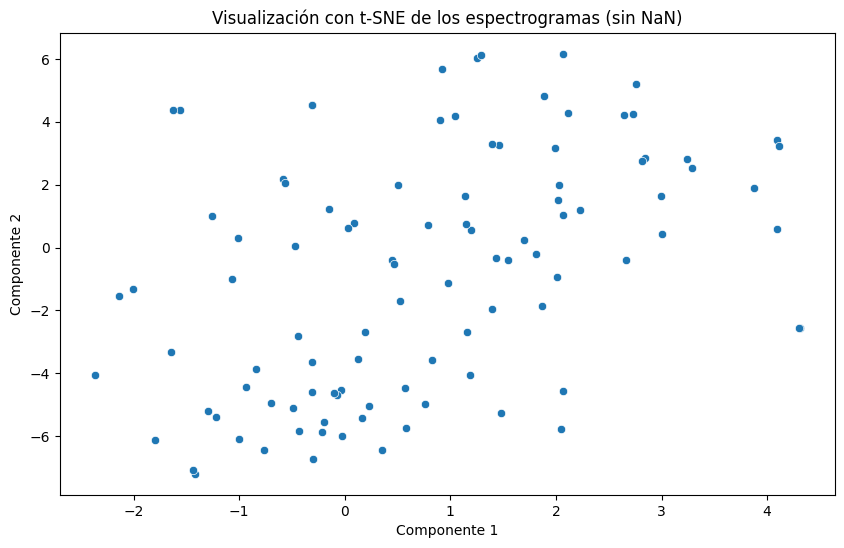

In [6]:
# Convertir lista de tensores a un tensor de PyTorch
X_tensor = torch.stack(X)  # (N, 256, 256)

# Reemplazar NaN con ceros
X_tensor = torch.nan_to_num(X_tensor, nan=0.0)

# Convertir a NumPy y aplanar los espectrogramas
X_numpy = X_tensor.numpy()
X_flat = X_numpy.reshape(X_numpy.shape[0], -1)  # (N, 65536)

# Aplicar t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_embedded = tsne.fit_transform(X_flat)  # (N, 2)

# Visualizar
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1])
plt.title("Visualización con t-SNE de los espectrogramas (sin NaN)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.show()


No se interpreta muy bien lo que significa cada componente, pero sin embargo, se puede observar que son notables distancias entre los puntos, por lo tanto, hay diferencia distinguible entre cada par de datos, y eso ayudará a saber que el autoencoder tiene margen de actuación.

Sí es observable que hay pares de puntos que están cerca enter sí, esto puede deberse a que las muestras de audio son 2 particiones de un mismo clip, y cabría esperar que haya semejanzas entre ellos, sin embargo, no se puede decir que ocurra todo el tiempo.

## Reconstrucción audio
Por último, a manera de demostración vamos a cargar un audio, procesarlo para conseguir su espectograma y a continuación lo reconstruiremos para que sea observable que se puede reconstruir el audio a partir de su espectograma y esto facilitará que podamos evaluar si el autoencoder funciona como esperaríamos.

In [7]:
archivo_cualquiera = os.listdir("./MusicCaps")[33] # Seleccionamos un archivo cualquiera

onda, samp_rt = torchaudio.load("./MusicCaps/" + archivo_cualquiera) # Cargamos
f, s = SplitAudio(onda, sample_rate = samp_rt, new_sample_rate = 16000) # Lo dividimos en el clip de 4,2 segundos
Audio(f.numpy(), rate=16000)

c:\Users\jpeir\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


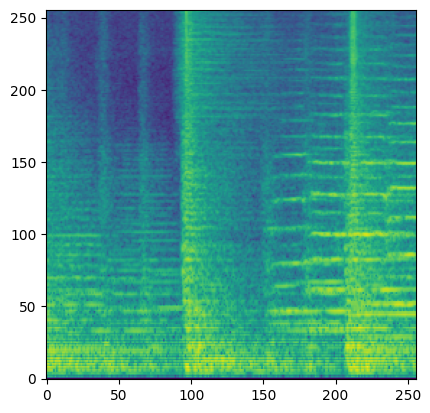

In [8]:
f_spec, f_maxi, f_mini = Preprocessing(f, 16000, resampler_f = False) # Convertimos el audio escuchado a espectograma
plt.imshow(f_spec,origin='lower') # Mostramos ese espectograma

In [9]:
reconstruction = Reconstruction(f_spec, f_maxi, f_mini) # Ahora reconstruimos a partir del espectograma generado
Audio(reconstruction.numpy(), rate=16000) # Escuchamos la recosntrucción

Así mostramos cómo podemos adquirir el espectograma de un audio cualquiera, que será el dato con el que trabajaremos, y después podemos volver a adquirir el audio al que referencia de manera fiable.

Animamos a probar otro audio cualquiera para poder observar que todo el procedimiento es correcto. Para ello se puede cambiar el número del archivo seleccionado.